<a href="https://colab.research.google.com/github/nshigeeda/surface_obs_plot/blob/main/surface_obs_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

実況気象通報式（SYNOP）・地域気象観測（アメダス）プロット<br>
2024_Dec_20作成, 2024_Dec_26更新, N.Shigeeda
# はじめに

このPythonコードは、実況気象通報式（SYNOP）と地域気象観測（アメダス）の実況観測データを取得し、これらのデータに基づく天気記号を地図上にプロットし、地上局地天気図（プロット図）を作成します。このプロット図を用いて、地上の等圧線、温度分布、シアラインの主観解析を行うことが可能です。<br>
　地上局地プロット図は東京学芸大学気象情報頁 専門天気図からDL可能ですが、このプロット図は北緯30度から44度付近をカバーする少し大きめの図です。例えば関東甲信地方に着目した局地解析を行いたい場合など、もう少し縮尺の小さいプロット図を使いたいことがあります。このような背景から、独自に指定する緯度経度範囲でプロット図を作成するコードを実装しました。<br>
　局地解析は、地形や降水などの実況も重ね合わせて行うことが有効です。地形図や雨雲合成レーダーなど他の情報をプロット図に重ね合わせることで、局地解析の精度を上げることが可能です。本コードはプロット図を背景透明な画像として保存するので、別途入手した他の画像（図）を重ね合わせて見ることができます。<br>
　地図の縮尺を小さくするとSYNOPの通報地点が相対的に減ります。そこで補完的にアメダスの実況観測データに基づく天気記号も同じ地図上にプロットします。これによりある程度精度のある局地解析を行えるようにしました。<br>
　SYNOPにおける風速は国によって運用が異なり、単位に関する情報も風速と一緒に通報されます。日本ではノットを使用しますが、中国・米国はm/sです。本コードでは、風速はノットをm/sに換算してプロットします。なおアメダスの風速は元からm/sで取得できるので単位の変換はしていません。風向は、SYNOPは36方位、アメダスは16方位です。それぞれ角度にした値をプロットします。SYNOPは、短矢羽：5m/s、長矢羽：10m/s、旗矢羽：50m/sです。アメダスは、短矢羽：1m/s、長矢羽：2m/s、旗矢羽：10m/sです。なおアメダスについては、wind_mag パラメータで強調度を変更可能です。<br>
　METARやSHIPも、SYNOPと同様にしてプロットすることは可能と思われますが現時点で未実装です。

## 実況気象通報式について

1. データソースあれこれ<br>
    実況気象通報式は次のサイトから入手可能です。それぞれ良し悪しがあるので、目的に応じて扱いやすい情報ソースを選択する必要があります。主観的になりますが、今回のプロット図作成を念頭に置いて利点と欠点をあげます。
    - NCEI NOAA（https://www.ncei.noaa.gov/data/global-hourly/）<br>
    **［利点］** 過去の実況気象データを入手できる。観測が始まっていない等でデータのある地点は限られますが、一番古いデータは1901年からあります。観測データはcsv形式になっており、デコードされた値が格納されています。風速はm/sです。仕様書が整備されています（https://www.ncei.noaa.gov/data/global-hourly/doc/）<br>
    **［欠点］** 地点毎、1年分のデータが一つのファイルに収まっています。プロット図のように複数地点をプロットするには複数のファイルをDLし、対象時刻の観測データを選択的に抽出する必要があります。ファイル名は地点をユニークに識別するコードが使われていますが、国際地点番号の前に米国空軍の定義したコードがつけられているので、ファイル名を選択するのも工夫が要ります。<br>
    - Unidata（https://thredds.ucar.edu/thredds/catalog/catalog.html）<br>
    **［利点］** 過去1か月前までの SYNOP, SHIP, SYNOP MOBIL, METARが入手可能。但しMETARは別ディレクトリ。年月日時を単位とするtextファイルに複数地点のデータが格納されているので、プロット図を作成する際は一つのtextファイルをDLすれば済みます。データの提供システムはThredds data server(TDS)なので、siphonライブラリを使ってAPI経由でデータを取得可能。<br>
    **［欠点］** 最新データの反映が遅い時がある。データの反映が遅いときは、昨日今日の観測に基づくプロット図を作成することはできません。データはWMOの仕様に基づいてSYNOPを包む形でエンコードされているらしく、SYNOPを扱うためには、まずSYNOPデータを取り出す必要があります。※METARはデータの抽出とデコードまでを一貫して行うAPIがMETPYに用意されている。<br>
    - 東京学芸大学気象情報頁 専門天気図（http://tenki.u-gakugei.ac.jp/advanced.html）<br>
    **［利点］** 最新データの反映が一番早く、昨日今日の観測に基づくプロット図を作成できます。データは、00/03/06/09/12/15/1/8/21UTC毎のtextファイルになっており、ひとつのtextファイルに複数地点のSYNOPが格納されているので、対象時刻のプロット図を生成する時はひとつのファイルをDLすれば済みます。<br>
    **［利点］** データは過去1週間前までしか遡れないため、それ以前の災害事例などを取り上げて解析したい場合は、別のデータソースを頼るしかありません。<br>

2. 実況気象通報式のデコードについて<br>
    SYNOP報のデコードには pymetdecoder というライブラリが利用できます（https://pypi.org/project/pymetdecoder/）。<br>
    - このライブラリはそこそこの頻度で更新されているようで、2024.12.25時点で v0.1.6が利用可能です。SYNOP (FM-12), SHIP (FM-13), SYNOP MOBIL (FM-14)に対応しています。pymetdecoderは、風向を角度にデコードしてくれます。なおアメダスについては本コード内で16方位を角度に変換しています。<br>
    - ところでMETARについては、Metpy の parse_metar_file というメソッドを用いると簡単にデコードしてくれます。(https://unidata.github.io/MetPy/latest/api/generated/metpy.io.parse_metar_file.html) 本コードではMETARのプロットはしていないため使用していません。このようなメソッドがMETARにはあって、なぜSYNOPにはないのかはわかりません。<br>

3. 緯度経度情報について<br>
    - SYNOPには緯度経度情報が含まれないません。SYNOPについては、定置地上観測所の識別コードをキーにして、国際地点番号表から緯度経度情報を求めています。<br>

## 地域気象観測システム（アメダス）の観測データについて

1. データソースについて
    気象庁アメダスのホームページはその要素がjson形式で構成されており、アメダス観測データもその一部。よってアメダス観測データの取得は、その構成要素の中から表示する観測データに相当するjsonのURLを直接指定して取得する。このjsonの構造に関する仕様は公開されておらず、将来のデータの取得方法については非保証であり、ホームページの改善等により任意のタイミングで変わる可能性がある。
    - 地点リスト https://www.jma.go.jp/bosai/amedas/const/amedastable.json
    - 最新データの時刻 https://www.jma.go.jp/bosai/amedas/data/latest_time.txt
    - 観測データ（年月日時毎のjsonデータ） https://www.jma.go.jp/bosai/amedas/data/map/20241220090000.json<br>
        ※およそ10日ほど前までのデータが取得できる。
2. アメダス観測データの解析処理（parse）について
    データのタイムゾーンはJSTなので、SYNOPプロット図に重ねる際は、取得するデータをUTCに換算する必要がある。<br>
    アメダスの風向データは16方位で格納されている。
3. 緯度経度情報<br>
    アメダス観測データ（json）にも緯度経度情報は含まれていません。先ずアメダス観測地点リストを取得して、そこから緯度経度情報を求めています。

## プロット図の描画について

データの可視化は Metpy の PlotObs class と MapPanel classを使用します。最初に PlotObs インスタンスを作成・セットし、そのあと MapPanel で図法の指定やプロット図の体裁を指定します。詳細は MetpyのTutorialを参照ください。https://unidata.github.io/MetPy/latest/tutorials/declarative_tutorial.html#

## 謝辞及び免責

本コードの実装に際しては、次のサイトを参考にさせていただきました。ありがとうございます。
   - 天気図の世界 https://note.com/rkurora/n/n0a9eb8d4d08e
   - Pythonによる気象データサイエンス　https://www.dpac.dpri.kyoto-u.ac.jp/enomoto/pymetds/JSON.html

実況気象通報式のデータは教育・研究目的で提供されているものです。本コードによるプロット図の商用利用はご遠慮ください。<br>
アメダス実況観測データの取得方法やjson構造は仕様が公開されていません。将来に渡って動作を保証するものではありません。<br>
本コードによって作成したプロット図は、正確性・完全性を保証するものではございません。また本コードの利用に際しては、その利用方法に応じて著作権やその他の知的財産権を侵害しないことを確認のうえご利用ください。当方はこれに起因する損害について一切の責任を負いません。

## 仕様書及びAPI reference

* 仕様書関連（気象庁サイト）<br>
    - 国際気象通報式 https://www.jma.go.jp/jma/kishou/books/tsuhoshiki/tsuhoshiki.html
    - 国際地点番号表 https://www.jma.go.jp/jma/kishou/books/station/station.html
* 主なライブラリのAPI reference<br>
    - Metpy https://unidata.github.io/MetPy/latest/api/index.html
    - Pymetdecoder https://pypi.org/project/pymetdecoder/
    - Cartopy https://scitools.org.uk/cartopy/docs/latest/reference/index.html
    - Matplotlib https://matplotlib.org/stable/api/index.html

## Google colaboratory 環境について

このコードを Google colaboratory で実行することができます。最初に下記インストールコマンドのコメント行を有効化してライブラリをインストールしてください。
コードが出力するデータを Google Drive に保存する場合は、スクリプト実行前にドライブをマウントする必要があります。<br>

In [ ]:
# google colaboratory環境にインストールするライブラリ
!pip install metpy
!pip install siphon
!pip install cartopy
!pip install pymetdecoder

In [ ]:
# ドライブをマウントする場合は有効化する
# from google.colab import drive
# drive.mount('/content/drive')

----

# コード本体　ライブラリの読み込み

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import math
import openpyxl
from datetime import datetime,timedelta
import requests
from io import StringIO
#
from pymetdecoder import synop as s
#
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#
import metpy.io as metar
from metpy.units import units
import metpy.calc as mpcalc
from metpy.plots import (add_metpy_logo, simple_layout, StationPlot, StationPlotLayout, wx_code_map)
from metpy.plots import current_weather, sky_cover, PlotObs
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)
from metpy.plots.wx_symbols import current_weather_auto
from metpy.plots.wx_symbols import low_clouds, mid_clouds, high_clouds
from metpy.plots.wx_symbols import pressure_tendency

In [ ]:
# test code
# pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

# プロットする年月日時・領域指定 ★プロット図作成前に編集
基本的な実行前の設定は次の通りです。
   - 1st STEP プロットするSYNOP及びアメダスデータの日時をUTCで指定します。<br>
   - 2nd STEP プロット範囲を指定します。<br>
［注意］アメダスの風速を当倍率でプロットすると風の弱い地点の矢羽が表示されません。局地解析は風向が重要な要素なので、風速に強調パラメータ（wind_mag）をかけて風速が小さくても矢羽がプロットされるようにしています。これが気になる場合は wind_mag=0 をセットしてください。なおSYNOPは観測値を当倍率で表示します。

In [ ]:
### 各種パラメータ設定
## プロット時刻の指定 ※注意UTCで指定
# 学芸大学専門天気図の更新時刻は、観測時刻の約3時間05分後
year = 2024
month = 12
day = 25
hour = 21  # 00,03,06,09,12,15,18,21(UTC)
#
## プロット範囲 緯度・経度
# fig_area = [100,160,24,60]  #  アジア西太平洋
# fig_area = [120,150,20,48]  # 日本付近
# #fig_area = [126,135,30,36]  # 九州付近
# fig_area = [129,137,30,37]  # 西日本付近
# fig_area = [135.6,141.6,33,39]  # 東日本付近
fig_area = [137.0,141.2,34.2,37.2]  # 関東甲信
# fig_area = [136,145,35,43]  # 東北付近
# fig_area = [136,150,40,48]  # 北海道付近
#
# アメダス風速の強調度 ※5.0をセットすると、1m/sで5m/sの表記、2m/sで10m/sの表記、10m/sで50m/sの矢羽表記
wind_mag = 5.0  # default は1.0をセットする SYNOPには効かないので注意！
#
# プロット地点の間引き度合い ※値を大きくするとプロットするデータが間引かれる プロット範囲に応じて変更
reduce_points = 0.0  # 日本付近：0.9、アジア西太平洋：1.6、それ以外：0.0
#
# 出力ファイル格納用フォルダ
data_directory = "./"
#
### 以下は基本変更しない
## データカット領域の指定
latMax = 90.0
latMin = 0.0
lonMax = 180.0
lonMin = 90.0
#
## 図のsize
fig_size = (13,13)
#
# Datatimeパラメータの生成(UTC及びJST)
tg_date = datetime(year, month, day, hour, 0, 0)
tg_date_jst = tg_date + timedelta(hours=9)

# アメダスデータ観測地点リスト及びjson取得と前処理

## アメダス地点リストの取得

In [ ]:
url = "https://www.jma.go.jp/bosai/amedas/const/amedastable.json"
with requests.get(url) as response:
    json = response.json() # python辞書型へ変換
    station_amedas = pd.DataFrame(json).transpose() # DataFrame化して、行と列を入れ替え
#
# 地点番号をstation_id列に変換
station_amedas = station_amedas.assign(index=station_amedas.index)
station_amedas.rename(columns={'index': 'station_id'}, inplace=True)

In [ ]:
# 緯度経度を十進に変換
station_amedas["latitude"] = station_amedas["lat"].str[0] + station_amedas["lat"].str[1]/60
station_amedas["longitude"] = station_amedas["lon"].str[0] + station_amedas["lon"].str[1]/60

In [ ]:
def get_latest():
    '''
    アメダスデータがある最新の時刻情報を取得する関数
    '''
    url = "https://www.jma.go.jp/bosai/amedas/data/latest_time.txt"
    with requests.get(url) as response:
        return datetime.fromisoformat(response.text).strftime("%Y%m%d%H%M")

## アメダスjsonの取得

In [ ]:
# アメダスデータの取得 ※アメダスデータはJSTで取る
latest = get_latest()
url_latest = "https://www.jma.go.jp/bosai/amedas/data/map/" + latest + "00.json"
# url = "https://www.jma.go.jp/bosai/amedas/data/map/20241220090000.json"  # 最新～9日程度前まで
url = 'https://www.jma.go.jp/bosai/amedas/data/map/'+f'{tg_date_jst.year}{tg_date_jst.month}{tg_date_jst.day}{tg_date_jst.hour:02d}'+'0000.json'  # 最新～9日程度前まで

with requests.get(url) as response:
    json = response.json()
amedas_df = pd.DataFrame(json).transpose()

## アメダスデータの前処理

In [ ]:
# データ列は値と品質フラグのリストになっているので，値を表す最初の要素を残す。また`dropna()`メソッドでNaNを取り除く。
for col in amedas_df.columns:
    amedas_df[col] = amedas_df[col].dropna().str[0].dropna()

In [ ]:
# 観測点の経度と緯度を観測所一覧から追加する。 amedas_dfがアメダスのDataFrame
amedas_df["longitude"] = station_amedas.loc[amedas_df.index, "longitude"]
amedas_df["latitude"] = station_amedas.loc[amedas_df.index, "latitude"]
amedas_df["station_id"] = station_amedas.loc[amedas_df.index, "station_id"]
amedas_df["enName"] = station_amedas.loc[amedas_df.index, "enName"]  # add by NS@Nov-03-2024

### アメダスデータに日時情報をdatetime型で追加 ※これはJSTであることに注意

In [ ]:
# date_time列を追加 ※JSTで取得したデータをUTC時刻で管理する
new_column_jst = pd.to_datetime(
    str(tg_date_jst.year) + '-' + str(tg_date_jst.month).zfill(2) + '-' +
    str(tg_date_jst.day).zfill(2) +  ' ' +
    str(tg_date_jst.hour).zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)
# date_time列の追加
amedas_df.loc[:,'date_time_jst'] = new_column_jst
#
new_column_utc = pd.to_datetime(
    str(tg_date.year) + '-' + str(tg_date.month).zfill(2) + '-' +
    str(tg_date.day).zfill(2) +  ' ' +
    str(tg_date.hour).zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)
# date_time列の追加
amedas_df.loc[:,'date_time'] = new_column_utc


In [ ]:
# 風向風速は16方位で報知されるので、角度にデコード
# windDirection = ["静穏" "北北東" "北東" "東北東" "東" "東南東" "南東" "南南東" "南" "南南西" "南西" "西南西" "西" "西北西" "北西" "北北西" "北"]
def wind_direction_to_angle(direction):
    """
    16方位の風向を角度に変換する関数。
    Parameters:  direction (str): 16方位の風向（例: '北', '北北東', '北東'）
    Returns:     float: 風向に対応する角度（0度が北、時計回り）
    """
    # 16方位と対応する角度の辞書
    direction_to_angle = {
        '0': 00, # 静穏
        '1': 22.5, # 北北東
        '2': 45.0, # 北東
        '3': 67.5, # 東北東
        '4': 90.0, # 東
        '5': 112.5, # 東南東
        '6': 135.0, # 南東
        '7': 157.5, # 南南東
        '8': 180.0, # 南
        '9': 202.5, # 南南西
        '10': 225.0, # 南西
        '11': 247.5, # 西南西
        '12': 270.0, # 西
        '13': 292.5, # 西北西
        '14': 315.0, # 北西
        '15': 337.5, # 北北西
        '16': 360.0, # 北
    }
    # 指定された風向に対応する角度を返す
    return direction_to_angle.get(direction, None)  # 存在しない場合は None を返す
#

### アメダスの風向風速からuv成分を計算する

In [ ]:
# 風向風速からuv成分を計算 ※アメダスの風速はm/sで統一されている前提
# 先ずアメダスの風向16方位を角度に変換
wind_deg = []
amedas_wind_ms = amedas_df.copy()
amedas_wind_direction = [ int(d) if d is not None and not math.isnan(d) else None
    for d in amedas_wind_ms['windDirection'].values ]
for i in range(len(amedas_wind_ms)):
    deg = wind_direction_to_angle(str(amedas_wind_direction[i]))
    wind_deg.append(deg)
amedas_wind_ms.loc[:,'windDirection_deg'] = wind_deg
#
# アメダスの風向風速からベクトル成分を計算する（観測値がm/sのデータ）
east_wind = []
north_wind = []
# amedas_wind_ms = amedas_df.copy()
amedas_wind_speed_ms = amedas_wind_ms['wind'].values
amedas_wind_deg = amedas_wind_ms['windDirection_deg'].values
for i in range(len(amedas_wind_ms)):
    ew = wind_mag * -1.0 * amedas_wind_speed_ms[i] * math.sin(amedas_wind_deg[i] * math.pi / 180.0)
    nw = wind_mag * -1.0 * amedas_wind_speed_ms[i] * math.cos(amedas_wind_deg[i] * math.pi / 180.0)
    east_wind.append(ew)
    north_wind.append(nw)
amedas_wind_ms.loc[:,'eastward_wind'] = east_wind
amedas_wind_ms.loc[:,'northward_wind'] = north_wind
#
# # それぞれのDataframeを行方向に結合
# syn_combined = pd.concat([syn_wind_ms, syn_wind_kt, syn_wind_calm, syn_wind_na], axis=0)
amedas_combined = amedas_wind_ms.copy() # DataFrameはひとつしかないのでcopyで対応
# インデックスをリセットしておく（おまじない）
amedas_combined.reset_index(drop=True, inplace=True)
#
# 検証用にアメダスデータをExcelファイルに保存しておく
path = data_directory + '/ame_' + f'{tg_date_jst.year}{tg_date_jst.month}{tg_date_jst.day}{tg_date_jst.hour:02d}' + 'JST.xlsx'
amedas_combined.to_excel(path)
#

## プロットデータ（アメダス用）の作成

In [ ]:
# 使う気象要素を抜き出してプロット用DataFrameを作成する
amedas_data = amedas_combined.copy()
amedas_data = amedas_data[['date_time','station_id','enName','longitude','latitude',
                     'temp','eastward_wind','northward_wind'
                     ]]
#

# SYNOPの取得と前処理

## 国際地点番号のリストを取得

In [ ]:
# 気象庁サイトから国際地点番号表を取得する
url = "https://www.jma.go.jp/jma/kishou/books/station/station.txt"
with requests.get(url) as response:
    # 取得したテキストデータを適切にパース
    text_data = response.text
    # StringIOを使ってpandasで読み込む（テキストデータをDataFrameに変換）
    # encoding が不明のため、日本語文字は化ける。とりあえず Shift-jis を指定しておく。
    station = pd.read_csv(StringIO(text_data), sep='\t', encoding='Shift-jis')  # tab区切りの場合はsep='\t'を使用

# 必要な列だけを取り出す
station_df = station[['IndexNbr','IndexSubNbr','Latitude','Longitude']].copy()
#

In [ ]:
def dms_to_degree(dms):
    '''
    緯度経度を十進度分秒（degree）に変換する関数
    '''
    # 度分秒を空白で各パーツに分割
    dms_parts = dms[:-1].strip().split()
    degrees = int(dms_parts[0])
    minutes = int(dms_parts[1])
    seconds = int(dms_parts[2])
    #
    # 度分秒を整数に変換
    try:
        return degrees + minutes / 60 + seconds / 3600  # 度に変換
    except ValueError:
        print(f"Invalid DMS format: {dms}")
        return None

In [ ]:
# 地点番号表の緯度経度を度分秒に変換する
station_df = station_df.copy()
station_df['LatitudeDegree'] = station_df['Latitude'].apply(dms_to_degree)
station_df['LongitudeDegree'] = station_df['Longitude'].apply(dms_to_degree)
#

## 学芸大学のサイトにアクセスしてSYNOP取得

In [ ]:
# 学芸大学SYNOPのURLを指定
f_name = f"synop_jk_{hour:02d}.txt"
url = f"http://tenki.u-gakugei.ac.jp/advanced/{f_name}"
#
# ファイルの格納先
f_path = data_directory + '/' + f_name
# データ取得
try:
    response = requests.get(url)
    response.raise_for_status()  # ステータスコードが200以外の場合に例外を発生させる
    content = response.text  # レスポンスの本文を取得
#
    # 検証用に取得した実況気象通報式をファイルに保存する
    with open(f_path, "w", encoding="utf-8") as file:
        file.write(content)

    print(f"コンテンツが正常に取得され、{f_path} に保存されました。")
#
except requests.exceptions.RequestException as e:
    print(f"コンテンツの取得中にエラーが発生しました: {e}")

In [ ]:
def parse_segment(seg):
    '''
    実況気象通報式をsegmentごとにデコードする関数
    デコード結果は辞書型がネストされているため、json_normalize()で平坦化した辞書型データを返す
    '''
    seg_dic = []
    try:
        parsed_seg = s.SYNOP().decode(seg)
        # seg_dic.append(parsed_seg)
    except Warning as e:
        pass
    except Exception as e:
        print(e)

    # 入れ子になっている辞書構造を平坦な辞書構造に変換する
    seg_df = pd.json_normalize(parsed_seg)

    return seg_df

In [ ]:
# test code
# content = "AAXX 15151 24944 41996 82303 11223 21254 39969 40285 52006 77172 82037="
#
# 実況気象通報式をSegmentに分割して、Segment毎にデコードする
syn_df = pd.DataFrame()
for x in content.split("AAXX"):
    # 空要素をスキップ
    if x.strip() == "":
        continue
    # セグメント毎にパース開始
    seg = "AAXX" + x
    df = parse_segment(seg)
    syn_df = pd.concat([syn_df, df], ignore_index=True)
#

## デコードしたSYNOPに必要な列を追加してDataFrameを整える

### 日時情報列の追加

In [ ]:
# date_time列を追加
new_column = pd.to_datetime(
    str(year) + '-' + str(month).zfill(2) + '-' +
    syn_df['obs_time.day.value'].astype(str) + ' ' +
    syn_df['obs_time.hour.value'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)
# pd.concat を使って列を一度に追加
syn_df = pd.concat([syn_df,  new_column.rename('date_time')], axis=1)
#

### 緯度経度情報列の追加

In [ ]:
# 地点番号表と実況気象通報式のそれぞれのDe-Taframeをmergeし、station_id.valueに対応する緯度経度の列を追加する
syn_df['station_id.value'] = syn_df['station_id.value'].astype(int)  # station_id.value を int に変換
syn_df = syn_df.merge(
    station_df,
    left_on='station_id.value',
    right_on='IndexNbr',
    how='left'  # 'left'で元のsyn_dfのデータを維持
)

In [ ]:
# 緯度経度の列名を変更
syn_df = syn_df.drop(columns={'Latitude','Longitude'})
syn_df = syn_df.rename(columns={'LatitudeDegree':'latitude','LongitudeDegree':'longitude'})
# station_idの列名を変更
syn_df= syn_df.rename(columns={'station_id.value':'station_id'})

### データ型の指定、NAに対する処理など

In [ ]:
# カラムの型変換とNaNの処理
syn_df['station_id'] = syn_df['station_id'].astype(str)
syn_df['cloud_cover.value'] = syn_df['cloud_cover.value'].fillna(9).astype(int) # NaNは”不明(9)”にする
syn_df['pressure_tendency.change.value'] = syn_df['pressure_tendency.change.value'].fillna(0) # NaNはひとまず0で埋める
syn_df['pressure_tendency.tendency.value'] = syn_df['pressure_tendency.tendency.value'].fillna(4).astype(int) # NaNはひとまず4（一定）で埋める
syn_df['present_weather.value'] = syn_df['present_weather.value'].fillna(00).astype(int) # NaNは00（雲の変化不明）で埋める

## 各種気象要素のクリーニングと前処理（SYNOP）

### 風向風速の処理（SYNOP用）

In [ ]:
# 風向風速からuv成分を計算 ※単位や欠損値を考慮
# 観測値が静穏のデータ
east_wind = []
north_wind = []
syn_wind_calm = syn_df[syn_df['surface_wind.direction.calm']==True].copy()
syn_wind_calm.loc[:, 'surface_wind.direction.value'] = '00'  # 風向'00'は静穏
for i in range(len(syn_wind_calm)):
    east_wind.append(0.0)  # 東西成分に0.0を入れる
    north_wind.append(0.0)  # 南北成分に0.0を入れる
syn_wind_calm.loc[:,'eastward_wind'] = east_wind
syn_wind_calm.loc[:,'northward_wind'] = north_wind
#
# 観測値がknotsのデータ
east_wind = []
north_wind = []
syn_wind_kt = syn_df[(syn_df['surface_wind.direction.calm']==False)&(syn_df['surface_wind.speed.unit']=='KT')].copy()
syn_wind_speed_kt = syn_wind_kt['surface_wind.speed.value'].values * 0.514  # knots -> m/s
syn_wind_direction = syn_wind_kt['surface_wind.direction.value'].values
for i in range(len(syn_wind_kt)):
    ew = -1.0 * syn_wind_speed_kt[i] * math.sin(syn_wind_direction[i] * math.pi / 180.0)
    nw = -1.0 * syn_wind_speed_kt[i] * math.cos(syn_wind_direction[i] * math.pi / 180.0)
    east_wind.append(ew)
    north_wind.append(nw)
# east_wind, north_wind = mpcalc.wind_components(syn_wind_speed_kt, syn_wind_direction)
syn_wind_kt.loc[:,'eastward_wind'] = east_wind
syn_wind_kt.loc[:,'northward_wind'] = north_wind
#
# 観測値がm/sのデータ
east_wind = []
north_wind = []
syn_wind_ms = syn_df[(syn_df['surface_wind.direction.calm']==False)&(syn_df['surface_wind.speed.unit']=='m/s')].copy()
syn_wind_speed_ms = syn_wind_ms['surface_wind.speed.value'].values
syn_wind_direction = syn_wind_ms['surface_wind.direction.value'].values
for i in range(len(syn_wind_ms)):
    ew = -1.0 * syn_wind_speed_ms[i] * math.sin(syn_wind_direction[i] * math.pi / 180.0)
    nw = -1.0 * syn_wind_speed_ms[i] * math.cos(syn_wind_direction[i] * math.pi / 180.0)
    east_wind.append(ew)
    north_wind.append(nw)
syn_wind_ms.loc[:,'eastward_wind'] = east_wind
syn_wind_ms.loc[:,'northward_wind'] = north_wind
#
# 観測値が静穏では無いのに風速が欠損値となっている観測データ
east_wind = []
north_wind = []
syn_wind_na = syn_df[(syn_df['surface_wind.direction.calm']==False)&
                       (syn_df['surface_wind.speed.unit']!='m/s')&(syn_df['surface_wind.speed.unit']!='KT')].copy()
for i in range(len(syn_wind_na)):
    east_wind.append(0.0)
    north_wind.append(0.0)
syn_wind_na.loc[:,'eastward_wind'] = east_wind
syn_wind_na.loc[:,'northward_wind'] = north_wind
#
# それぞれのDataframeを行方向に結合
syn_combined = pd.concat([syn_wind_ms, syn_wind_kt, syn_wind_calm, syn_wind_na], axis=0)
# インデックスをリセット（必要に応じて）
syn_combined.reset_index(drop=True, inplace=True)
#

### 気象要素の単位の設定　※不要かも

In [ ]:
# 単位を設定する
syn_combined['air_temperature.value'] = syn_combined['air_temperature.value'].values * units.degC
syn_combined['dewpoint_temperature.value'] = syn_combined['dewpoint_temperature.value'].values * units.degC
syn_combined['sea_level_pressure.value'] = syn_combined['sea_level_pressure.value'].values * units.hPa

### プロット用データフレームの作成

In [ ]:
# 使う気象要素を抜き出してプロット用DataFrameを作成する
syn_data = syn_combined.copy()
# syn_data.dtypes
syn_data = syn_data[['date_time','station_id','longitude','latitude',
                     'cloud_cover.value','air_temperature.value','dewpoint_temperature.value','sea_level_pressure.value',
                     'surface_wind.speed.value','surface_wind.direction.value','surface_wind.direction.calm',
                     'eastward_wind','northward_wind',
                     'present_weather.value','present_weather._table',
                     'pressure_tendency.change.value','pressure_tendency.change.unit',
                     'pressure_tendency.tendency.value','pressure_tendency.tendency._table'
                     ]]
#

# アメダスとSYNOPのプロット

### アメダス用プロット対象インスタンスの作成<br>
［注意］再プロットの場合はここから実行すること

In [ ]:
## AMEDAS temp：Plotするための準備  PlotObsインスタンス作成
amedas_obs = PlotObs()
amedas_obs.data = amedas_data
amedas_obs.time = tg_date
amedas_obs.level = None # Surface data
#
# plotするデータの指定、表示位置、文字の色、Format、矢羽
amedas_obs.fields = ['temp']
# amedas_obs.plot_units = ['degC']
amedas_obs.locations = ['C']
amedas_obs.colors = ['deepskyblue'] # orange
amedas_obs.fontsize = 10
amedas_obs.formats = [None]
amedas_obs.vector_field = ['eastward_wind', 'northward_wind']
amedas_obs.vector_field_color = 'deepskyblue' # orange
amedas_obs.reduce_points = reduce_points
#

### SYNOP用プロット対象インスタンスの作成

In [ ]:
## SYNOP：Plotするための準備  PlotObsインスタンス作成
obs = PlotObs()
obs.data = syn_data
obs.time = tg_date
obs.level = None # Surface data
#
# plotするデータの指定、表示位置、文字の色、Format、矢羽
obs.fields = [
  'cloud_cover.value',
  'air_temperature.value',
  'dewpoint_temperature.value',
  'sea_level_pressure.value',
  'pressure_tendency.change.value',
  'pressure_tendency.tendency.value',
  'present_weather.value'
  ]
# obs.plot_units = [None, 'degC', 'degC', None]
obs.locations = ['C', 'NW', 'SW', 'NE', 'E', 'SE', 'W']
obs.colors = ['black', 'tab:red', 'tab:green', 'black', 'black', 'black', 'black']
obs.fontsize = 10
obs.formats = ['sky_cover',
               None,
               None,
               lambda v: format(10 * v, '.0f')[-3:],
               lambda x: format(10 * x, '02g')[:3],
               'pressure_tendency',
               'current_weather'
               ]
obs.vector_field = ['eastward_wind', 'northward_wind']
obs.reduce_points = reduce_points
#

### プロット図の描画実行

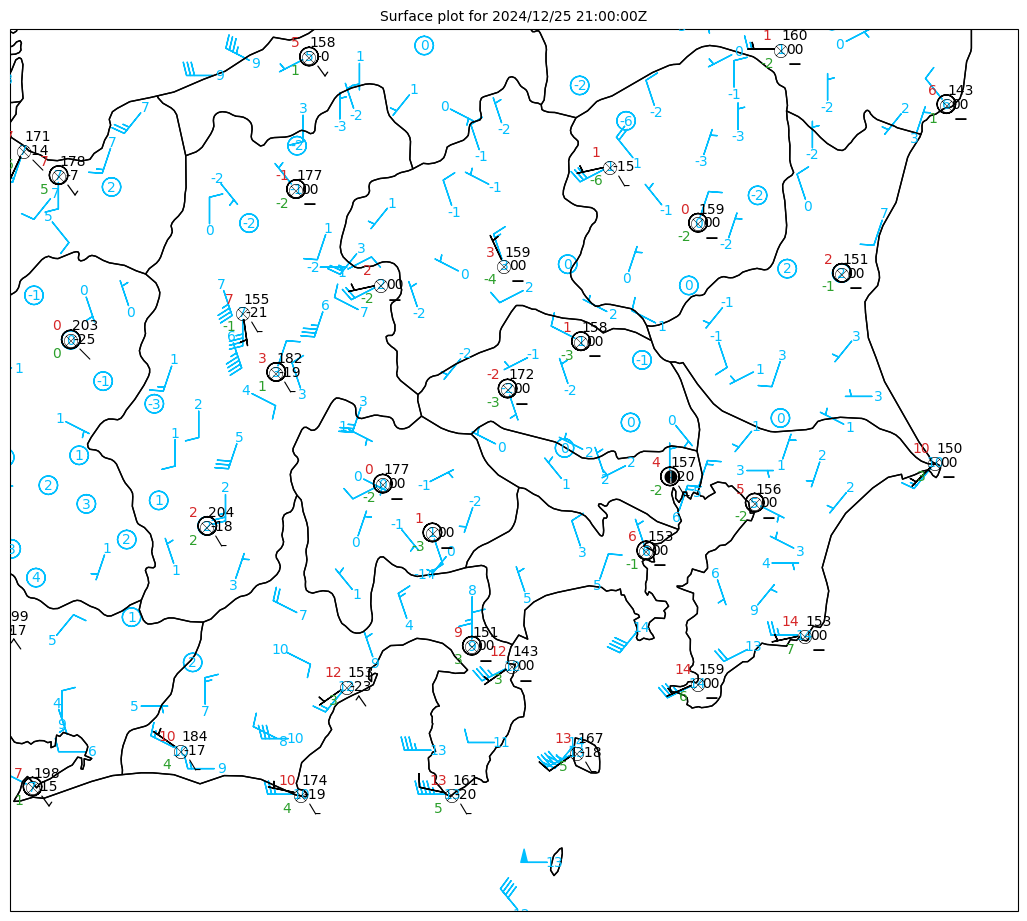

In [ ]:
### プロット図の描画
## Map パネルのクラスを利用して、地図のエリア、投影、描画する地図要素、
panel = MapPanel()
panel.layout = (1, 1, 1)
panel.area = fig_area

#  投影する図法
# crs = ccrs.AzimuthalEquidistant(central_longitude=140) # 正距方位図法 地理院地図と次に当てはまりが良い
# crs = ccrs.LambertConformal(central_longitude=140)
# crs = ccrs.LambertAzimuthalEqualArea(central_longitude=140)
crs = ccrs.Mercator(central_longitude=140.0) # 地理院地図と当てはまりが良い
# panel.projection = 'lcc'
panel.projection = crs
# # panel.projection = ccrs.PlateCarree()
#
## 表示指定
panel.layers = ['coastline', 'borders', 'states']
# panel.layers = ['coastline', 'borders', 'states', 'land', 'ocean']
#
# panel.plots = [amedas_barbs] # AMEDAS barbs
panel.plots = [amedas_obs, obs] # AMEDAS & SYNOP
# panel.plots = [amedas_obs]  # AMEDASのみ
# panel.plots = [obs]    # SYNOPのみ
#
## タイトル
panel.title = 'Surface plot for ' + obs.time.strftime("%Y/%m/%d %H:%M:%SZ")
#
## 一般的な図のパネルのクラスを利用して、図の大きさ、表示するパネルを指定
pc = PanelContainer()
pc.size = fig_size
pc.panels = [panel]
#
# showing results
pc.show()
#
# プロット図をファイル保存
fname = data_directory + '/' + tg_date.strftime('%Y%m%d%H') + 'UTC' + "_plot.png"
pc.save(fname, transparent=True)  # transparent=True で背景を透明にする

----
EOF<br>